In [1]:
using Distributions
using Random
using DelimitedFiles
using ParticleFilters
using PyPlot
using StatsBase
using Images
using BenchmarkTools
using CUDA
using Serialization

## Load Data

#### Bathymetry Map (for measurement model)

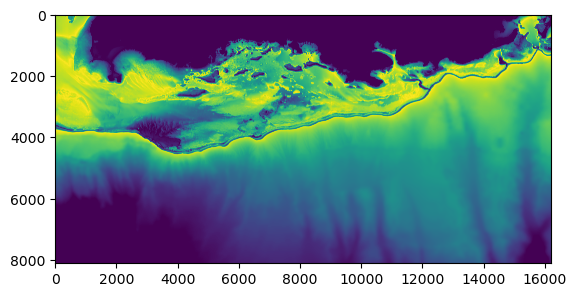

In [2]:
# Open the tiff file
filename = "PuertoRico_SouthWest_Color.tif"
img = load(filename)

function rgb_to_value(rgb_color::RGB{N0f8})
    # Interpolate between blue and red based on the green component
    green_component = green(rgb_color)
    value = 30-30 * (1 - green_component)

    # Return the value
    return value
end

function lookup_depth(x, y, map)
    # In meters
    # column, row (x, y) format. 0, 0 is top left of image    
    
    # Find the pixel with the closest x, y values
    x_idx = argmin(abs.(collect(1:size(map, 2)) .- x))
    y_idx = argmin(abs.(collect(1:size(map, 1)) .- y))
    
    # Look up the pixel value
    pixel_value = map[y_idx, x_idx] 
    
    return pixel_value 
end

# Apply the rgb_to_value function to the image
value_image = map(rgb_to_value, img)

# Display the value image
imshow(value_image)

bathy_map = value_image[1500:2500,6000:8000];

## Particle Filter Models
Use closures to create dynamics and measurement models

#### Dynamics Model

In [3]:
function glider_dynamics_model(x, u, rng, delta_t)
    """
    inputs:
        x: state
        u: control input
    output:
        updated state (same shape as x)
    """
    x_pos, y_pos, θ, v, dθ = x
    in_thruster, in_rudder = u
    
    # Update position based on state
    x_step = x_pos + delta_t*v*cos(θ)
    y_step = y_pos + delta_t*v*sin(θ)
    θ_step = θ + delta_t*dθ

    # Update velocities based on input
    v_step = v + delta_t*(in_thruster-v)
    dθ_step = dθ + delta_t*in_rudder
    
    return [x_step, y_step, θ_step, v_step, dθ_step]
end

function generate_dynamics_model(delta_t)
    return (x, u, rng) -> glider_dynamics_model(x, u, rng, delta_t)
end

# dynamics_model = generate_dynamics_model(delta_t)

generate_dynamics_model (generic function with 1 method)

#### Measurement Model

In [4]:
# Measurement Model
# (computes likelihood of measurement, given previous state, action, and current state)
# Note: our measurement only depends on current state
function glider_measurement_model(x1, u, x2, y, measurement_std, bathy_map)
    """
    inputs:
        x1: current state
        u: control input
        x2: next state
        y: measurement
    output:
        likelihood (float)
    """
    
    # State vector: x, y, θ, linear velocity, angular velocity
    x_pos, y_pos, θ, v, dθ = x2
    measured_depth = y
    
    model_depth = lookup_depth(x_pos, y_pos, bathy_map)

    dist = Normal(model_depth, measurement_std)
    pdf_value = pdf(dist, measured_depth)

    return pdf_value
end

function generate_measurement_model(measurement_std, bathy_map)
    return (x1, u, x2, y) -> glider_measurement_model(x1, u, x2, y, measurement_std, bathy_map)
end

# measurement_model = generate_measurement_model(measurement_std, bathy_map)

generate_measurement_model (generic function with 1 method)

## Generate Dataset

In [5]:
function generate_random_func()
    n = 5
    a = 0.05
    A = rand(-a:0.01:a, n)
    B = rand(-a:0.01:a, n)
    random_func(t) = sum(A[i]*sin.(B[i]*t) * A[i+1]*cos.(B[i+1]*t) for i in 1:n-1)
    return random_func
end

function generate_data_from_func(ts, func)
    output = similar(ts)
    for (i, t) in enumerate(ts)
        output[i] = func(t)
    end
    return output
end

function simulate_trajectory(ts, in_thruster, in_rudder; start_x=0, start_y=0, start_θ=0, delta_t=0.1)
    xs = similar(ts)
    ys = similar(ts)
    vs = similar(ts)
    θs  = similar(ts)
    dθs = similar(ts)
    
    # Initialize state to 0
    xs[1] = start_x # X position
    ys[1] = start_y # Y position
    vs[1] = 0 # Velocity
    θs[1] = start_θ # Heading
    dθs[1] = 0 # Angular Velocity
    
    for (i, t) in enumerate(ts[1:end-1])
        state = [xs[i], ys[i], θs[i], vs[i], dθs[i]]
        u = [in_thruster[i], in_rudder[i]]
        xs[i+1], ys[i+1], θs[i+1], vs[i+1], dθs[i+1] = 
            glider_dynamics_model(state, u, rng, delta_t)
    end
    
    return xs, ys, θs, vs, dθs
end

function simulate_measurements(xs, ys, map, measurement_std)
    output = similar(xs)
    
    noise_dist = Normal(0, measurement_std)
    
    for (i, (x, y)) in enumerate(zip(xs, ys))
        output[i] = lookup_depth(x, y, map) + rand(noise_dist)
    end
    
    return output
end

simulate_measurements (generic function with 1 method)

#### Preview & Save Generated Trajectory
Note: For consistency in benchmarking, we'll save a couple trajectories and only use those instead of generating random ones for each test. This code is commented out because it doesn't need to be run 

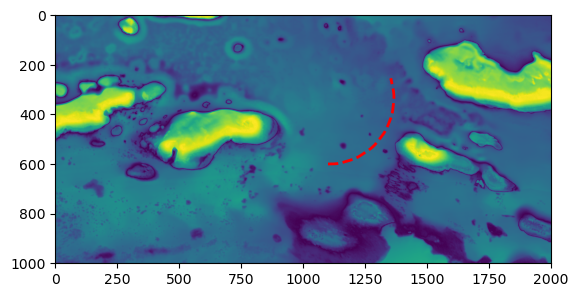

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000220491177C0>

In [6]:
# Start in middle of map
START_X = 1100 
START_Y = 600
START_θ = 0

# START_X = 500 
# START_Y = 200
# START_θ = 0

# For previewing
SIM_TIME = 1000 # s
N_STEPS = 1001

ts = range(0, stop=SIM_TIME, length=N_STEPS)
DELTA_T = ts[2] - ts[1]
rng = MersenneTwister(1)

generated_func = generate_random_func()
in_thruster = 0.5*ones(size(ts))
in_rudder = 0.1*generate_data_from_func(ts, generated_func)

xs, ys, θs, vs, dθs = simulate_trajectory(ts, in_thruster, in_rudder, 
    start_x=START_X, start_y=START_Y, start_θ=START_θ, delta_t=DELTA_T)

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(xs,ys,"r--", lw=2)

In [7]:
# # Save Function to file, if desired
# open("generated_func7.jls", "w") do io
#     serialize(io, generated_func)
# end

#### Dataset Generator Functions

In [8]:
function generate_data(start_x, start_y, start_θ, sim_time, n_steps, input_func, bathy_map, measurement_std)
    ts = range(0, stop=sim_time, length=n_steps)
    delta_t = ts[2] - ts[1]
    
    in_thruster = 0.5*ones(size(ts))
    in_rudder = 0.1*generate_data_from_func(ts, input_func)

    xs, ys, θs, vs, dθs = simulate_trajectory(ts, in_thruster, in_rudder, 
        start_x=start_x, start_y=start_y, start_θ=start_θ, delta_t=delta_t)

    measurements = simulate_measurements(xs, ys, bathy_map, measurement_std)
    
    return xs, ys, θs, vs, dθs, in_thruster, in_rudder, measurements
end

generate_data (generic function with 1 method)

## ParticleFilters.jl

In [9]:
function compute_initial_particles(n_particles, init_std_pos, init_std_rot, start_x, start_y, start_θ)
    init_particles = Vector{Vector{Float64}}(undef, n_particles)
    
    dist_pos_init = Normal(0, init_std_pos)
    dist_rot_init = Normal(0, init_std_rot)
    
    for i in 1:n_particles
        # Generate sample
        x = start_x + rand(dist_pos_init)
        y = start_y + rand(dist_pos_init)
        θ = start_θ + rand(dist_rot_init)
        init_particles[i] = [x, y, θ, 0, 0]
    end

    return init_particles
end

compute_initial_particles (generic function with 1 method)

In [10]:
function bench_pf(
        n_particles, init_std_pos, init_std_rot, measurement_std, bathy_map, # Modelling params
        start_x, start_y, start_θ, sim_time, n_steps, input_func, # Dataset params
        num_evals, num_samples) # Benchmarking params
    
    delta_t = range(0, stop=sim_time, length=n_steps)[2] - 
              range(0, stop=sim_time, length=n_steps)[1]
    
    dynamics_model = generate_dynamics_model(delta_t)
    measurement_model = generate_measurement_model(measurement_std, bathy_map)
    
    pf_model = ParticleFilterModel{Vector{Float64}}(dynamics_model, measurement_model)

    fil = BootstrapFilter(pf_model, n_particles) # Takes in model, number of particles

    # construct initial belief
    init_particles = compute_initial_particles(n_particles, 
            init_std_pos, init_std_rot, start_x, start_y, start_θ)
    b0 = ParticleCollection(init_particles)
    
    xs, ys, θs, vs, dθs, in_thruster, in_rudder, measurements = 
        generate_data(start_x, start_y, start_θ, sim_time, n_steps, input_func, bathy_map, measurement_std)

    # Plot initial samples
    fig, ax = PyPlot.subplots()
    ax.imshow(-bathy_map)
    for p in init_particles
        ax.plot(p[1], p[2], "r.")
    end
    
    # Convert inputs to usable form for pf
    inputs = [in_thruster, in_rudder]

    # Preallocate the output vector for performance
    us = Vector{Vector{Float64}}(undef, length(in_thruster))

    # Convert each pair of values to a vector and store in the output vector
    for i in 1:length(in_thruster)
        us[i] = [inputs[1][i], inputs[2][i]]
    end

    # Actually compute results. Inputs: filter, initial particles, data 
    pf_result = runfilter(fil, b0, us, measurements); 
#     bench_result = @benchmark runfilter($fil, $b0, $us, $measurements) evals=num_evals samples=num_samples
#     display(bench_result)
    elapsed_time = @elapsed runfilter(fil, b0, us, measurements); 
    display(elapsed_time)
    
    # Plot results
    filtered_xs = [m[1] for m in map(mean, pf_result)]
    filtered_ys = [m[2] for m in map(mean, pf_result)]
    fig, ax = PyPlot.subplots()
    ax.imshow(-bathy_map)
    ax.plot(xs,ys,"r--", lw=2)
    ax.plot(filtered_xs, filtered_ys, "y")
    
    return elapsed_time, pf_result
end

bench_pf (generic function with 1 method)

#### CPU Benchmark Test

0.1821324

1.6870806

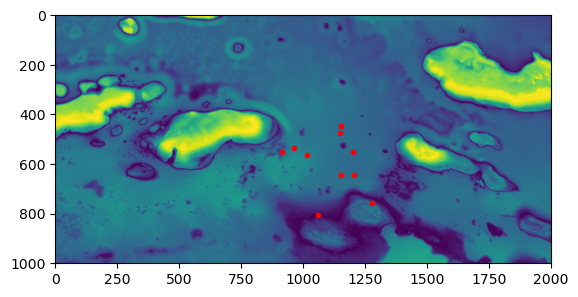

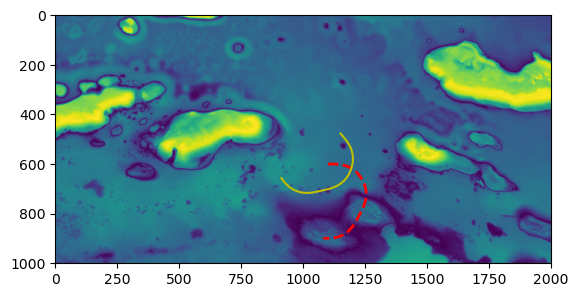

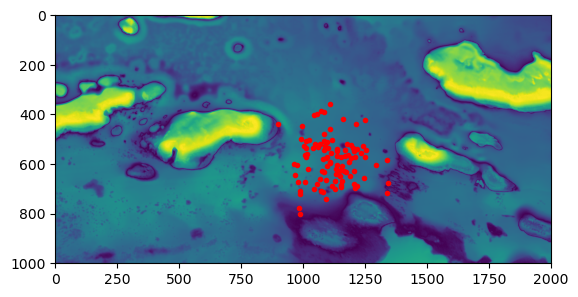

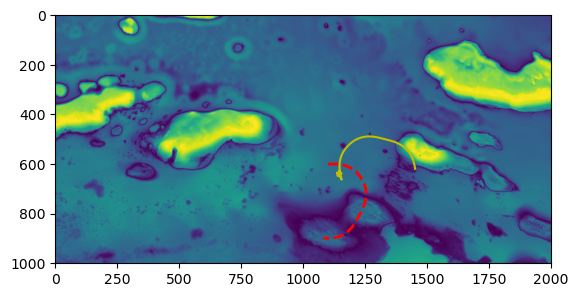

In [132]:
# Load function
loaded_func = deserialize(open("generated_func3.jls"))

# Functions 1, 2, 5
# start_x = 500
# start_y = 200

# Functions 3, 4, 5
start_x = 1100 
start_y = 600

init_std_pos = 100
init_std_rot = 1
measurement_std = 0.01
start_θ = 0
sim_time = 1000
n_steps = 1001
input_func = loaded_func
num_evals = 1
num_samples = 1

# n_particles_test = [10, 100, 1000, 2000, 3000]
n_particles_test = [10, 100]

for n_particles in n_particles_test
    bench_result, pf_result = bench_pf(n_particles, init_std_pos, init_std_rot, measurement_std, bathy_map,
            start_x, start_y, start_θ, sim_time, n_steps, input_func,
            num_evals, num_samples);
end

## ParticleFiltersGPU.jl

In [121]:
function runfiltergpu!(particles, inputs, measurements, 
        reweight_kernel!, propogate_kernel!, output_particles, pf_data)
    num_steps = length(inputs)
    num_particles = size(particles)[1]
    
    # Initialize weights vector
    weights_d = CUDA.fill(1.0f0, num_particles)
    
    # Initialize cumulative distribution vector
    cdf_d = similar(weights_d)
    
    # Initialize space to copy particle data - needed for resampling step
    particle_buffer = similar(particles)
    copyto!(particle_buffer, particles)
    
    # TODO: Optimize threads vs blocks
    # TODO: clean this up - all threads, blocks the same
    # Initialize kernel configurations
    reweight_kernel = @cuda launch=false reweight_kernel!(particles, inputs[1], measurements[1], weights_d, pf_data)
    reweight_config = launch_configuration(reweight_kernel.fun)
    reweight_threads = min(num_particles, reweight_config.threads)
    reweight_blocks = cld(num_particles, reweight_threads)

#     display("Reweight Threads: $reweight_threads")
#     display("Reweight Blocks: $reweight_blocks")
    
    resample_kernel = @cuda launch=false resample_kernel!(particles, particle_buffer, cdf_d)
    resample_config = launch_configuration(resample_kernel.fun)
    resample_threads = min(num_particles, resample_config.threads)
    resample_blocks = cld(num_particles, resample_threads)

#     display("Resample Threads: $resample_threads")
#     display("Resample Blocks: $resample_blocks")
    
    propogate_kernel = @cuda launch=false propogate_kernel!(particles, inputs[1], pf_data)
    propogate_config = launch_configuration(propogate_kernel.fun)
    propogate_threads = min(num_particles, propogate_config.threads)
    propogate_blocks = cld(num_particles, propogate_threads)

#     display("Propogate Threads: $propogate_threads")
#     display("Propogate Blocks: $propogate_blocks")
    
    synchronize()
    
    for idx in range(1, num_steps)
        u = inputs[idx]
        y = measurements[idx]
        
        # STEP 1: Compute weights ------------------
        CUDA.@sync begin
            reweight_kernel(particles, u, y, weights_d, pf_data; threads=reweight_threads, blocks=reweight_blocks)
        end
        
        # Compute CDF
        cumsum!(cdf_d, weights_d)
        cdf_d ./= cdf_d[end]

        # Copy particles to buffer 
        copyto!(particle_buffer, particles) # TODO: remove this, it's redundant with the all particles saved
        copyto!(output_particles[idx], particles)
        
        synchronize()
        
        # STEP 2: Resample particles ---------------
        CUDA.@sync begin
            resample_kernel(particles, particle_buffer, cdf_d; threads=resample_threads, blocks=resample_blocks)
        end
        
        # Propogate particles
        CUDA.@sync begin
            propogate_kernel(particles, u, pf_data; threads=propogate_threads, blocks=propogate_blocks)
        end
    end
end

runfiltergpu! (generic function with 1 method)

In [122]:
function glider_reweight_kernel!(particles, input, measurement, weights, pf_data)   
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x
    
    # Extract data from pf_data
    bathy_map = pf_data.bathy_map
    measurement_std = pf_data.measurement_std
    ϵ = pf_data.ϵ
    
    for i = index:stride:size(particles)[1]
        # Lookup nearest point on map
        # TODO: Convert x, y value to pixels
        @inbounds x = particles[i, 1] 
        @inbounds y = particles[i, 2]

        ix, iy = round(Int, x), round(Int, y)
        # Clamp pixel indices to image bounds
        ix = max(min(ix, size(bathy_map, 2)), 1)
        iy = max(min(iy, size(bathy_map, 1)), 1)

        # Compute likelihood given measurement
        μ = bathy_map[iy, ix]
        measured_depth = measurement[1]
        σ = measurement_std
        likelihood = exp(-0.5 * ((measured_depth - μ)/σ)^2) / (σ * sqrt(2π))

        # Enforce minimum bound on likelihood
        if likelihood < ϵ
            likelihood = ϵ
        end

        @inbounds weights[i] = likelihood
    end

    return nothing
end

# Encodes glider dynamics
function glider_propogate_kernel!(particles, input, pf_data)
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x
    
    # Extract data from pf_data
    delta_t = pf_data.delta_t
    
    for i = index:stride:size(particles)[1]
        @inbounds x_pos = particles[i, 1]
        @inbounds y_pos = particles[i, 2]
        @inbounds θ = particles[i, 3]
        @inbounds v = particles[i, 4]
        @inbounds dθ = particles[i, 5]
        
        @inbounds in_thruster = input[1]
        @inbounds in_rudder = input[2]
    
        # Update position based on state
        particles[i, 1] = x_pos + delta_t*v*cos(θ)
        particles[i, 2] = y_pos + delta_t*v*sin(θ)
        particles[i, 3] = θ + delta_t*dθ

        # Update velocities based on input
        particles[i, 4] = v + delta_t*(in_thruster-v)
        particles[i, 5] = dθ + delta_t*in_rudder
    end
    
    return nothing
end

function resample_kernel!(particles, particle_buffer, cdf)
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x
    
    # Resample each particle
    # Approach - generate random number, find which CDF index
    # correlates with the random number. Values with higher likelihood
    # cover a wider range of values, and are consequently more likely
    # to be selected
    for i = index:stride:size(particles)[1]
        r = rand()
        
        # Use binary search to find corresponding index
        # TODO: evaluate how much this matters
        lo, hi = 1, size(particles)[1]
        while lo < hi
            mid = (lo + hi) ÷ 2
            if r < cdf[mid]
                hi = mid
            else
                lo = mid + 1
            end
        end
        idx = lo
        
        # TODO: Add noise terms
        # TODO: Make this more generic
        # Update particles
        particles[i, 1] = particle_buffer[idx, 1] + randn()*1
        particles[i, 2] = particle_buffer[idx, 2] + randn()*1
        particles[i, 3] = particle_buffer[idx, 3] + randn()*0.002
        particles[i, 4] = particle_buffer[idx, 4]
        particles[i, 5] = particle_buffer[idx, 5]
    end
    
    return nothing
end


resample_kernel! (generic function with 1 method)

In [186]:
function bench_pf_gpu(n_particles, init_std_pos, init_std_rot, measurement_std, bathy_map,
        start_x, start_y, start_θ, sim_time, n_steps, input_func,
        num_evals, num_samples, plot=true)
    
    dist_pos_init = Normal(0, init_std_pos)
    dist_rot_init = Normal(0, init_std_rot)

    xs, ys, θs, vs, dθs, in_thruster, in_rudder, measurements = 
        generate_data(start_x, start_y, start_θ, sim_time, n_steps, input_func, bathy_map, measurement_std)

    # Initialize particles
    x = Float32.(start_x .+ rand(dist_pos_init, n_particles))
    y = Float32.(start_y .+ rand(dist_pos_init, n_particles))
    θ = Float32.(start_θ .+ rand(dist_rot_init, n_particles))
    v = zeros(Float32, n_particles)
    dθ = zeros(Float32, n_particles)

    if plot
        # Plot initial samples
        fig, ax = PyPlot.subplots()
        ax.imshow(-bathy_map)
        ax.plot(x, y, "r.")
    end
        
    # Load particles onto GPU
    particles_d = CuArray([x y θ v dθ])

    # Load measurements and control inputs onto GPU
    in_thruster_32 = Float32.(in_thruster)
    in_rudder_32 = Float32.(in_rudder)
    inputs_d = [CuArray([in_thruster_32[i], in_rudder_32[i]]) for i in 1:length(in_thruster_32)]

    measurements_32 = Float32.(measurements)
    measurements_d = [CuArray([measurements_32[i],]) for i in 1:length(measurements_32)];

    # Format data for kernels
    bathy_map_d = CuArray(bathy_map);
    pf_data = GliderParticleFilterData(sim_time, n_steps, measurement_std, ϵ, delta_t, cudaconvert(bathy_map_d))

    # Allocate space for particle output
    output_particles_d = [similar(particles_d) for i in 1:n_steps]

    # Run filter
    elapsed_time = @elapsed runfiltergpu!(particles_d, inputs_d, measurements_d, 
        glider_reweight_kernel!, glider_propogate_kernel!, output_particles_d, pf_data)
    
    # Plot results
    pf_estimate = ones(n_steps, 2)

    for (idx, p) in enumerate(output_particles_d)
        pf_estimate[idx,1] = mean(p[:,1])
        pf_estimate[idx,2] = mean(p[:,2])  
    end
    
    if plot
        fig, ax = PyPlot.subplots()
        ax.imshow(-bathy_map)
        ax.plot(xs,ys,"r--", lw=2)
        ax.plot(pf_estimate[:,1], pf_estimate[:,2], "y")
    end
        
    display("Time: $elapsed_time")
    
    # Compute average error
    error = mean(sqrt.((pf_estimate[:,1] - xs).^2 + (pf_estimate[:,2] - ys).^2))
    display("Average Error: $error")
    
    return elapsed_time, output_particles_d, error
end

bench_pf_gpu (generic function with 2 methods)

#### GPU Benchmark Test

In [187]:
struct GliderParticleFilterData
    # Used to pass data into kernel functions
    sim_time::Float32
    n_steps::Int32
    measurement_std::Float32
    ϵ::Float32
    delta_t::Float32
    bathy_map::CuDeviceMatrix{Float32, 1}
end

"Time: 1.3705815"

"Average Error: 57.451344686694405"

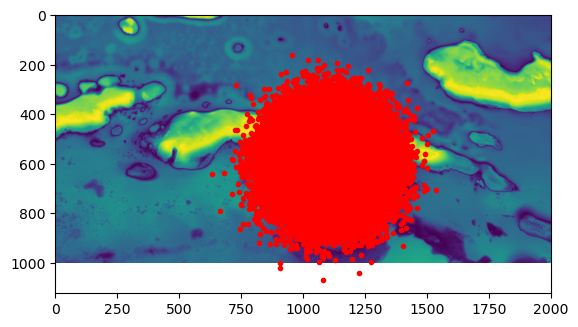

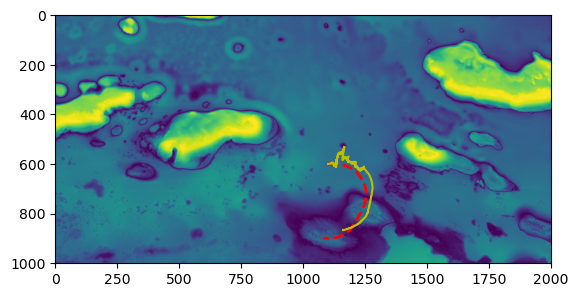

In [188]:
# Load function
loaded_func = deserialize(open("generated_func3.jls"))

# Functions 1, 2, 5
# start_x = 500
# start_y = 200

# Functions 3, 4, 5
start_x = 1100 
start_y = 600

init_std_pos = 100
init_std_rot = 1
measurement_std = 0.2
start_θ = 0
sim_time = 1000
n_steps = 1001
input_func = loaded_func
num_evals = 1
num_samples = 1

delta_t = range(0, stop=sim_time, length=n_steps)[2] - range(0, stop=sim_time, length=n_steps)[1]

# Needed for specific implementation - avoids particle death where no particles have weight
ϵ = 0.0000001


# n_particles_test = [10, 100, 1000, 2000, 3000]
n_particles_test = [100000] #150000

for n_particles in n_particles_test
    bench_result, pf_result, error = bench_pf_gpu(n_particles, init_std_pos, init_std_rot, measurement_std, bathy_map,
            start_x, start_y, start_θ, sim_time, n_steps, input_func,
            num_evals, num_samples, true);
end

In [189]:
# Load function
loaded_func = deserialize(open("generated_func3.jls"))

# Functions 1, 2, 5
# start_x = 500
# start_y = 200

# Functions 3, 4, 5
start_x = 1100 
start_y = 600
init_std_pos = 100
init_std_rot = 1
measurement_std = 0.01
start_θ = 0
sim_time = 1000
n_steps = 1001
input_func = loaded_func
num_evals = 1
num_samples = 1

delta_t = range(0, stop=sim_time, length=n_steps)[2] - range(0, stop=sim_time, length=n_steps)[1]

# Needed for specific implementation - avoids particle death where no particles have weight
ϵ = 0.0000001

num_trials = 2
n_particles_test = [10, 100, 1000, 2000, 3000, 10000, 20000, 50000, 100000, 150000]

timing_results = ones(num_trials, size(n_particles_test)[1])
error_results = ones(num_trials, size(n_particles_test)[1])

for (p_idx, n_particles) in enumerate(n_particles_test)
    for trial_idx in range(1,num_trials)
        bench_result, pf_result, error = bench_pf_gpu(n_particles, init_std_pos, init_std_rot, measurement_std, bathy_map,
                start_x, start_y, start_θ, sim_time, n_steps, input_func,
                num_evals, num_samples, false);
        timing_results[trial_idx, p_idx] = bench_result
        error_results[trial_idx, p_idx] = error
    end
end

"Time: 1.6341476"

"Average Error: 107.4636392665522"

"Time: 1.5492611"

"Average Error: 207.5532211797764"

"Time: 1.6291838"

"Average Error: 260.1380412907308"

"Time: 1.5911082"

"Average Error: 239.5635842851069"

"Time: 2.0387978"

"Average Error: 90.44622913042768"

"Time: 2.0052872"

"Average Error: 31.388408920209354"

"Time: 2.0331104"

"Average Error: 5.696554843128103"

"Time: 2.0393706"

"Average Error: 215.92934877605776"

"Time: 2.0524327"

"Average Error: 6.361243963933"

"Time: 2.0383742"

"Average Error: 7.573517308160526"

"Time: 2.0826315"

"Average Error: 13.45030901048558"

"Time: 2.0568371"

"Average Error: 11.734837785129068"

"Time: 2.2885976"

"Average Error: 9.55792804109735"

"Time: 2.2674974"

"Average Error: 9.158267551052468"

"Time: 2.5977087"

"Average Error: 9.808446767220886"

"Time: 2.4409337"

"Average Error: 9.09468261272794"

"Time: 0.9747246"

"Average Error: 10.02789622482014"

"Time: 0.4808761"

"Average Error: 10.284498486242184"

"Time: 0.638063"

"Average Error: 9.32145124830448"

"Time: 0.6427222"

"Average Error: 12.007777004520106"

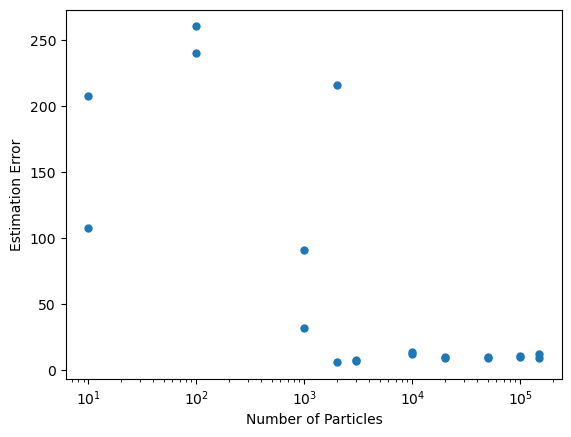

PyObject Text(0.5, 24.0, 'Number of Particles')

In [193]:
fig, ax = PyPlot.subplots()
for r_idx in range(1, size(error_results)[1])
    ax.plot(n_particles_test, error_results[r_idx, :],".", color="tab:blue", markersize=10)
    ax.set_xscale("log")
end
ax.set_ylabel("Estimation Error")
ax.set_xlabel("Number of Particles")
# ax.plot(pf_estimate[:,1], pf_estimate[:,2], "y")

In [ ]:
fig, ax = PyPlot.subplots()
for r_idx in range(1, size(timing_results)[1])
    ax.plot(n_particles_test, timing_results[r_idx, :],".", color="tab:blue", markersize=10)
    ax.set_xscale("log")
end
ax.set_ylabel("Time (s)")
ax.set_xlabel("Number of Particles")
# ax.plot(pf_estimate[:,1], pf_estimate[:,2], "y")

In [116]:
a = ones(10,5)
a[1,5] = 5
a

10×5 Matrix{Float64}:
 1.0  1.0  1.0  1.0  5.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0

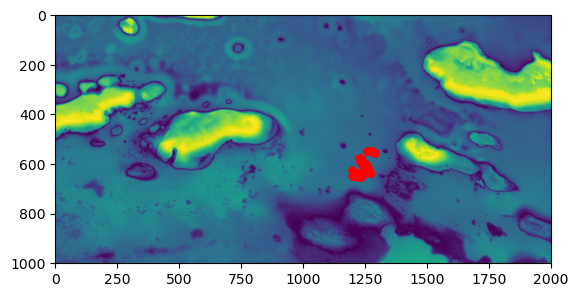

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000220C77DF3D0>

In [110]:
n = 300

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(pf_result[n][:,1], pf_result[n][:,2], "r.")

In [18]:
# b = CUDA.CuDeviceMatrix{Float64}(bathy_map_d)
typeof(cudaconvert(bathy_map_d))

LoadError: UndefVarError: bathy_map_d not defined

In [17]:
SIM_TIME = 1000 # s
N_STEPS = 1001

SIM_MEASUREMENT_STD = 10 # Noise of simulated measurement
MODEL_MEASUREMENT_STD = 0.2#10.0 #0.1 # Modeled noise value
ϵ = 0.000001 # Minimum particle likelihood value, to avoid errors

ts = range(0, stop=SIM_TIME, length=N_STEPS)

# TODO: remove fixed timestamp
DELTA_T = ts[2] - ts[1]
rng = MersenneTwister(1)

# Particle filter parameters
N_PARTICLES = 1000
INIT_STD_POS = 100 # Positional standard deviation
INIT_STD_ROT = 1 # Rotational standard deviation (radians)

PF_STD_POS = 0.1 # Positional standard deviation for particle filter updates
PF_STD_ROT = 0.01 # Positional standard deviation for particle filter updates


STATE_VEC_SIZE = 5 # x, y, θ, linear velocity, angular velocity



5

In [27]:
# results = @benchmark runfilter(fil, b0, us, measurements) evals=1 samples=1 

In [28]:
# results = @benchmark 3 evals=1000 samples=1
# @btime runfilter(fil, b0, us, measurements); # Actually compute results. Inputs: filter, initial particles, data 

In [29]:
# # TODO: make this less redundant
# filtered_xs = [m[1] for m in map(mean, bs)]
# filtered_ys = [m[2] for m in map(mean, bs)]

# fig, ax = PyPlot.subplots()
# ax.imshow(-bathy_map)
# ax.plot(xs,ys,"r--", lw=2)
# ax.plot(filtered_xs, filtered_ys, "y")

In [30]:
# bathy_map[1,400]
# bathy_map[1,600]
# bathy_map[600,1]
bathy_map[435,1]
# bathy_map_d[435, 1]

0.94117737f0

## Custom ParticleFilter 

In [31]:
dist_pos_init = Normal(0, INIT_STD_POS)
dist_rot_init = Normal(0, INIT_STD_ROT)

dist_pos_update = Normal(0, PF_STD_POS)
dist_rot_update = Normal(0, PF_STD_ROT)

Normal{Float64}(μ=0.0, σ=0.01)

In [32]:
# Load initial particles onto GPU (_d means stored on device)
using CUDA

N_PARTICLES = 10000

# Initialize particles
x = Float32.(START_X .+ rand(dist_pos_init, N_PARTICLES))
y = Float32.(START_Y .+ rand(dist_pos_init, N_PARTICLES))
θ = Float32.(START_θ .+ rand(dist_rot_init, N_PARTICLES))
v = zeros(Float32, N_PARTICLES)
dθ = zeros(Float32, N_PARTICLES)

# Load particles onto GPU
particles_d = CuArray([x y θ v dθ])
# Particles = Vector containing CuArray for each state variable 
# Vector{CuArray}(undef, 5)
# particles = [broadcast(tuple, x[i], y[i], θ[i], v[i], dθ[i]) for i in 1:length(x)]
# particles_d = CuArray(map(x -> (x[1], x[2], x[3], x[4], x[5]), particles))
# particles_d = CuArray([x', y', θ', v', dθ'])

# TODO: THIS IS TEMPORARY
# particles_d = cu(x)
# particles_d = CuArray(rand(Float32, N_PARTICLES, 5))

xs, ys, θs, vs, dθs, in_thruster, in_rudder, measurements = 
    generate_data(start_x, start_y, start_θ, sim_time, n_steps, input_func, bathy_map, measurement_std)
    

# Load measurements and control inputs onto GPU
in_thruster_32 = Float32.(in_thruster)
in_rudder_32 = Float32.(in_rudder)
inputs_d = [CuArray([in_thruster_32[i], in_rudder_32[i]]) for i in 1:length(in_thruster_32)]

measurements_32 = Float32.(measurements)
measurements_d = [CuArray([measurements_32[i],]) for i in 1:length(measurements_32)];

LoadError: UndefVarError: measurements not defined

┌ Warning: Performing scalar indexing on task Task (runnable) @0x000001de5daf5940.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArraysCore C:\Users\amyng\.julia\packages\GPUArraysCore\HaQcr\src\GPUArraysCore.jl:106


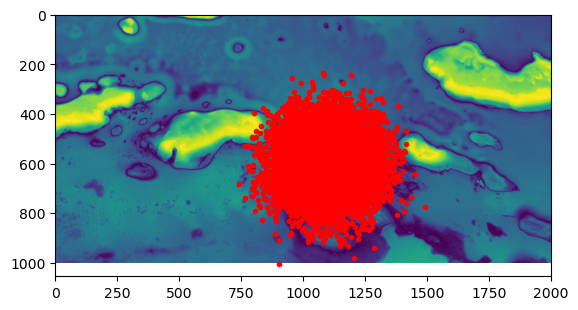

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001DEC35986A0>

In [33]:
fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(particles_d[:,1], particles_d[:,2], "r.")

In [31]:
# # cu([cu(START_X .+ rand(dist_pos_init, N_PARTICLES)), cu(START_Y .+ rand(dist_pos_init, N_PARTICLES))])
# a = [1,2,3]
# b = [1,1,1]
# # cu([a b])

# cu([x y])

In [32]:
# Load bathymetry map onto gpu
const bathy_map_d = CuArray(bathy_map);

In [33]:
# # particles_d
# bathy_map_d[1001,1]

In [34]:
# size(bathy_map_d)
size(bathy_map_d)

(1001, 2001)

In [35]:
# LEFT OFF HERE: - just pass in data as needed, 
# size(particles_d)
particles_d

10000×5 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
  892.631  610.148  3.04276   0.0  0.0
  961.283  513.341  2.99747   0.0  0.0
  903.925  577.538  2.20579   0.0  0.0
 1064.45   520.582  1.56663   0.0  0.0
  929.263  721.405  1.01917   0.0  0.0
 1112.88   603.83   1.05567   0.0  0.0
  859.017  482.568  2.29754   0.0  0.0
  990.625  837.374  1.22821   0.0  0.0
 1133.74   528.461  2.27257   0.0  0.0
 1135.66   521.107  1.63818   0.0  0.0
 1095.94   660.215  0.872261  0.0  0.0
 1003.74   645.842  2.54467   0.0  0.0
 1015.84   527.304  0.641289  0.0  0.0
    ⋮                              
 1034.41   547.374  2.28754   0.0  0.0
 1079.71   469.666  2.83821   0.0  0.0
  994.73   549.252  1.96327   0.0  0.0
 1122.15   630.529  0.752032  0.0  0.0
 1015.63   705.291  2.43826   0.0  0.0
 1107.6    577.391  1.29878   0.0  0.0
 1027.25   642.047  2.48748   0.0  0.0
 1012.73   577.384  0.866944  0.0  0.0
 1016.02   601.725  1.4191    0.0  0.0
  952.482  696.898  2.18968   0.0  0.0
  844.202  558.

In [120]:


#     sync_threads()
    
#     # STEP 2: Resample particles ----------------------------------------------
#     # Copy particles over to buffer
#     copyto!(particle_buffer, particles)
    
# function resample_func!(particles, particle_buffer, weights, cdf)
    
#     copyto!(particle_buffer, particles)
    
#     # Compute cumulative distribution function 
#     # Normalize weights
#     sync_threads()
#     total = sum(weights)

#     particles[1,4] = sum(weights)
    
#     acc_weights = cumsum(weights)
#     acc_weights ./= acc_weights[end]
    
# end

function bench_gpu_filter!(particles, inputs, measurements, 
        reweight_kernel!, propogate_kernel!, _all_particles, _bathy_map)
    num_steps = length(inputs)
    num_particles = size(particles)[1]
    
    # Initialize weights vector
    weights_d = CUDA.fill(1.0f0, num_particles)
    
    # Initialize cumulative distribution vector
    cdf_d = similar(weights_d)
    
    # Initialize space to copy particle data - needed for resampling step
    particle_buffer = similar(particles)
    copyto!(particle_buffer, particles)
    
    # TODO: Optimize threads vs blocks
    # TODO: clean this up - all threads, blocks the same
    # Initialize kernel configurations
    reweight_kernel = @cuda launch=false reweight_kernel!(particles, inputs[1], measurements[1], weights_d, _bathy_map)
    reweight_config = launch_configuration(reweight_kernel.fun)
    reweight_threads = min(num_particles, reweight_config.threads)
    reweight_blocks = cld(num_particles, reweight_threads)

#     display("Reweight Threads: $reweight_threads")
#     display("Reweight Blocks: $reweight_blocks")
    
    resample_kernel = @cuda launch=false resample_kernel!(particles, particle_buffer, cdf_d)
    resample_config = launch_configuration(resample_kernel.fun)
    resample_threads = min(num_particles, resample_config.threads)
    resample_blocks = cld(num_particles, resample_threads)

#     display("Resample Threads: $resample_threads")
#     display("Resample Blocks: $resample_blocks")
    
    propogate_kernel = @cuda launch=false propogate_kernel!(particles, inputs[1])
    propogate_config = launch_configuration(propogate_kernel.fun)
    propogate_threads = min(num_particles, propogate_config.threads)
    propogate_blocks = cld(num_particles, propogate_threads)

#     display("Propogate Threads: $propogate_threads")
#     display("Propogate Blocks: $propogate_blocks")
    
    synchronize()
    
    for idx in range(1, num_steps)
        u = inputs[idx]
        y = measurements[idx]
        
        # STEP 1: Compute weights ------------------
        CUDA.@sync begin
            reweight_kernel(particles, u, y, weights_d, _bathy_map; threads=reweight_threads, blocks=reweight_blocks)
        end
        
        # Compute CDF
        cumsum!(cdf_d, weights_d)
        cdf_d ./= cdf_d[end]

        # Copy particles to buffer 
        copyto!(particle_buffer, particles) # TODO: remove this, it's redundant with the all particles saved
        copyto!(_all_particles[idx], particles)
        
        synchronize()
        
        # STEP 2: Resample particles ---------------
        CUDA.@sync begin
            resample_kernel(particles, particle_buffer, cdf_d; threads=resample_threads, blocks=resample_blocks)
        end
        
        # Propogate particles
        CUDA.@sync begin
            propogate_kernel(particles, u; threads=propogate_threads, blocks=propogate_blocks)
        end
    end
end

display(particles_d)
# For saving output
all_particles_d = [similar(particles_d) for i in 1:N_STEPS]
bench_gpu_filter!(particles_d, inputs_d, measurements_d, glider_reweight_kernel!, glider_propogate_kernel!, all_particles_d, bathy_map_d)
# TODO: need to reset data before re-running this, since particles change
# @benchmark bench_gpu_filter!(particles_d, inputs_d, measurements_d, 
#     glider_reweight_kernel!, glider_propogate_kernel!, all_particles_d, bathy_map_d) evals=1 samples=1

LoadError: UndefVarError: particles_d not defined

In [37]:
# 
all_particles_d[3]

10000×5 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
  966.881  572.38    1.47936   0.5  1.19884f-5
  945.028  601.911   1.05832   0.5  1.19884f-5
 1041.39   581.232   1.72856   0.5  1.19884f-5
  965.337  634.062   1.30391   0.5  1.19884f-5
  972.324  578.406  -0.152665  0.5  1.19884f-5
  914.575  668.872   2.86987   0.5  1.19884f-5
  975.092  650.746  -0.425931  0.5  1.19884f-5
  930.122  600.766   1.35024   0.5  1.19884f-5
  863.894  586.455   1.25174   0.5  1.19884f-5
 1003.39   599.746   0.958769  0.5  1.19884f-5
  969.368  646.876   3.6178    0.5  1.19884f-5
  967.187  627.257  -0.675306  0.5  1.19884f-5
  965.958  604.138   1.33558   0.5  1.19884f-5
    ⋮                               
  992.295  592.625   1.09393   0.5  1.19884f-5
  955.041  573.701   1.67861   0.5  1.19884f-5
  859.244  621.938   0.868311  0.5  1.19884f-5
  943.594  574.435   1.80708   0.5  1.19884f-5
  976.536  607.295   2.27482   0.5  1.19884f-5
 1023.66   602.335   0.611498  0.5  1.19884f-5
  974.39   606.213

In [38]:
μ = 5
measured_depth = 6
σ = 1
exp(-0.5 * (measured_depth - μ / σ)^2) / (σ * sqrt(2π))

0.24197072451914337

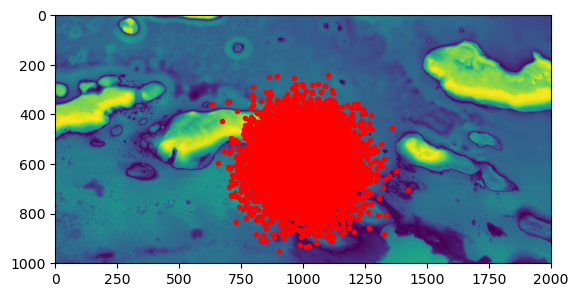

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001EA0D8F62F0>

In [39]:
n = 1

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(all_particles_d[n][:,1], all_particles_d[n][:,2], "r.")

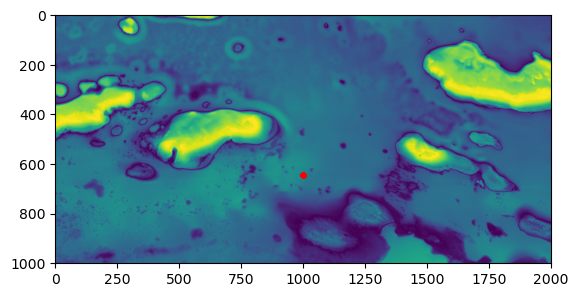

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001E9700F1840>

In [40]:
n = 600

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(all_particles_d[n][:,1], all_particles_d[n][:,2], "r.")

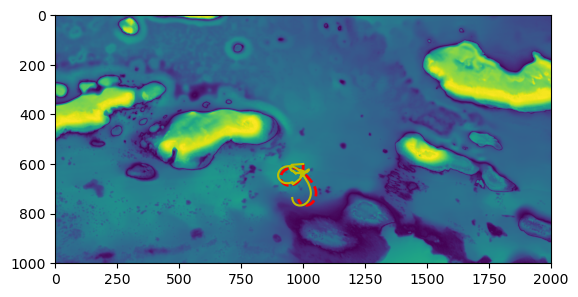

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000001EA00DB97E0>

In [41]:
pf_estimate = ones(N_STEPS, 2)

for (idx, p) in enumerate(all_particles_d)
    pf_estimate[idx,1] = mean(p[:,1])
    pf_estimate[idx,2] = mean(p[:,2])  
end

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(xs,ys,"r--", lw=2)
ax.plot(pf_estimate[:,1], pf_estimate[:,2], "y")

# SANDBOX

In [471]:
# # test = cu([rand(dist_pos_init, N_PARTICLES); rand(dist_pos_init, N_PARTICLES)])
# # test[1]

# temp1 = [1,2,3]
# temp2 = [4,5,6]
# A = Float32[temp1'; temp2']

# # Create a 2x3 matrix on the GPU with Float32 element type
# A_d = cu(A)

bathy_map_d

1001×2001 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 20.8235  20.8235  20.9412  20.9412  …  24.1176  24.1176  24.1176  24.1176
 20.8235  20.8235  20.9412  20.9412     24.1176  24.1176  24.1176  24.1176
 20.8235  20.8235  20.9412  20.9412     24.1176  24.1176  24.1176  24.1176
 20.9412  20.9412  20.9412  20.9412     24.1176  24.1176  24.1176  24.1176
 20.9412  20.9412  20.9412  21.0588     24.2353  24.2353  24.2353  24.2353
 20.9412  20.9412  20.9412  21.0588  …  24.2353  24.2353  24.2353  24.2353
 20.9412  20.9412  20.9412  21.0588     24.1176  24.2353  24.2353  24.2353
 20.9412  20.9412  20.9412  21.0588     24.0     24.1176  24.1176  24.1176
 20.9412  20.9412  20.9412  20.9412     24.0     24.0     24.0     24.1176
 20.9412  20.9412  20.9412  20.9412     23.8824  24.0     24.0     24.0
 20.9412  20.9412  20.9412  20.9412  …  23.8824  24.0     24.0     24.0
 20.9412  20.9412  20.9412  20.9412     23.8824  23.8824  23.8824  24.0
 20.9412  20.9412  20.9412  20.9412     23.8824  23.882

In [472]:
typeof(measurements_d)

Vector{CuArray{Float32, 1, DeviceBuffer}} (alias for Array{CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}, 1})

In [473]:
# function gpu_add3!(y, x)
#     index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
#     stride = gridDim().x * blockDim().x
#     for i = index:stride:length(y)
#         @inbounds y[i] += x[i]
#     end
#     return
# end

In [474]:
# # function run_gpu_filter!(particles, dynamics_model, measurement_model, inputs, measurements)
    
# # end

# function update_weights_gpu!(particles, input, measurement, measurement_model, weights)
#     index = (blockIdx().particles - 1) * blockDim().particles + threadIdx().particles
#     stride = gridDim().particles * blockDim().particles
#     for i = index:stride:length(particles)       
#         # TODO: Add support for measurement models that depend on next state
#         # Replace 0 with next state data
#         @inbounds weights[i] = measurement_model(particles[i], input, 0, measurement)
#     end
# end

# function run_gpu_filter!(particles, inputs, measurements, measurement_model, dynamics_model)
#     # Initialize weights vector
#     weights_d = CUDA.fill(1.0f0, length(particles))
    
#     for (u, y) in enumerate(zip(inputs, measurements))
#         print('.')
        
#         # TODO: Ensure likelihood can't be too small
#         update_weights_gpu!(particles, u, y, measurement_model, weights_d)
#     end
# end

# function bench_gpu_filter!(particles, inputs, measurements, measurement_model, dynamics_model)
# # function bench_gpu_filter!(particles, func)
#     kernel = @cuda launch=false run_gpu_filter!(particles, inputs, measurements, measurement_model, dynamics_model)
#     config = launch_configuration(kernel.fun)
#     threads = min(length(particles), config.threads)
#     blocks = cld(length(particles), threads)

#     display(threads)
#     display(blocks)

#     CUDA.@sync begin
#         kernel(particles, inputs, measurements, measurement_model, dynamics_model; threads, blocks)
# #         kernel(particles, func; threads, blocks)
#     end
# end

# bench_gpu_filter!(particles_d, inputs_d, measurements_d, glider_measurement_model, glider_dynamics_model)
# bench_gpu_filter!(particles_d, inputs_d, measurements_d)



# # function test_func!(part)
# #     display(part[1])
# #     display("here")
# #     @cuprintln("print testing")
# #     @cuprintln(part[1])
# # end

# # bench_gpu_filter!(particles_d, test_func!)

# # test_func!(particles_d)



# # # @btime bench_gpu4!($y_d, $x_d)

# # # run_gpu_filter!(particles_d, inputs_d, measurements_d)

# # @cuda threads=16 run_gpu_filter!(particles_d, inputs_d, measurements_d, glider_measurement_model, glider_dynamics_model)
# # synchronize()

10-element Vector{Float32}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [ ]:

# struct CustomParticleFilter
#     dynamics_model
#     measurement_model
# end

# # TODO: left off here
# function run_custom_filter!(filter, particles, inputs, measurements)
    
#     for (t_idx, (t, m, in_th, in_rud)) in enumerate(zip(ts, measurements, in_thruster, in_rudder))
#         print('.')
#         all_particles[:,:,t_idx] = particles


#         # Update weights based on observation ---------------------
#         # Compute relative likelihoods
#         for (p_idx, p) in enumerate(eachcol(particles))
#             weights[p_idx] = compute_likelihood(p, m, bathy_map)

#             # Ensure likelihood can't be too small
#             if weights[p_idx] < 0.000000001
#                 weights[p_idx] = 0.000000001
#             end
#         end   

#         # Resample particles --------------------------------------
#         # Normalize the weights


#     #     println("HEREEE")
#     #     println(size(weights))
#     #     println(sum(weights))
#     #     println(size(weights ./ sum(weights)))

#         w_norm = Weights(weights ./ sum(weights))

#         # Generate N_PARTICLES samples
#         samples = sample(1:size(particles, 2), w_norm, N_PARTICLES)

#         # Extract the corresponding columns from the matrix
#         new_particles = particles[:, samples]
#         particles = new_particles

#         # Add noise to avoid particle death
#         # TODO: Add noise to samples based on current covariances
#         particles[1, :] = particles[1, :] + rand(dist_pos_update, N_PARTICLES)
#         particles[2, :] = particles[2, :] + rand(dist_pos_update, N_PARTICLES)
#         particles[3, :] = particles[3, :] + rand(dist_rot_update, N_PARTICLES)

#         # Update particles with dynamics model 
#         # TODO add vehicle dynamics noise? (build in noise term here)
#         for (p_idx, p) in enumerate(eachcol(particles))
#             particles[:,p_idx] = glider_dynamics_model(p, DELTA_T, in_th, in_rud)
#         end   

#         # Update state estimate --------------------------------------
#         state_estimate[:,t_idx] = mean(particles, dims=2) # TODO: Handle angle wrap elegantly

#     #     # Visualization -------------------------------------------
#     #     fig, ax = PyPlot.subplots()
#     #     ax.imshow(-bathy_map)
#     #     ax.plot(particles[1,:], particles[2,:], "r.")

#     #     # Add the plot to the sequence
#     #     push!(plot_sequence, fig)
#     end

# end

# # INITIALIZATION ##############################################
# all_particles = ones(STATE_VEC_SIZE, N_PARTICLES, N_STEPS)
# particles = ones(STATE_VEC_SIZE, N_PARTICLES)
# new_particles = ones(STATE_VEC_SIZE, N_PARTICLES)
# weights = ones(N_PARTICLES)

# dist_pos_init = Normal(0, INIT_STD_POS)
# dist_rot_init = Normal(0, INIT_STD_ROT)

# dist_pos_update = Normal(0, PF_STD_POS)
# dist_rot_update = Normal(0, PF_STD_ROT)


# for i in range(1, N_PARTICLES)
#     # Generate sample
#     x = START_X + rand(dist_pos_init)
#     y = START_Y + rand(dist_pos_init)
#     θ = START_θ + rand(dist_rot_init)
    
#     particles[:,i] = particles[:,i].*[x, y, θ, 0, 0]
# end

# # Plot initial particles
# fig, ax = PyPlot.subplots(figsize=[10,10])
# ax.imshow(-bathy_map)
# ax.plot(particles[1,:], particles[2,:], "r.")


# # PARTICLE FILTER ##############################################
# state_estimate = ones(STATE_VEC_SIZE, N_STEPS)

# # pre-allocate space (avoids errors)
# samples = similar(weights)


# Sandbox

In [83]:
# # Note: this returns a number
# const sigma = 1.0
# g(x1, u, x2, y) = pdf(Normal(sigma), y-x2[1])

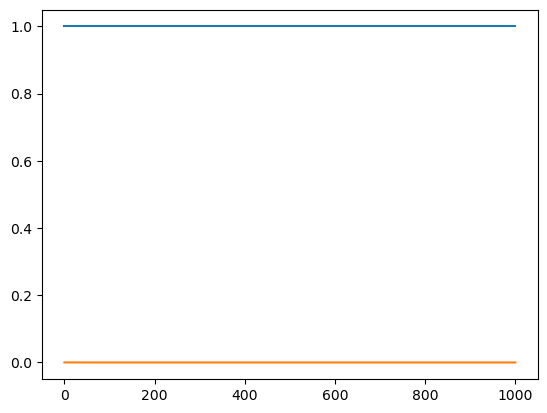

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F45A36590>

In [84]:
PyPlot.plot(in_thruster)
PyPlot.plot(in_rudder)

In [85]:
# plot(xs[1:100], ys[1:100])
# PyPlot.plot(xs, ys)

In [86]:
# plot(xs)
# plot!(ys)

## Measurement Model

In [87]:
size(value_image)


(8112, 16212)

lookup_depth (generic function with 1 method)

In [89]:
x = -100000000000
y = -1000000000000000000000
x_idx = argmin(abs.(collect(1:size(bathy_map, 2)) .- x))
y_idx = argmin(abs.(collect(1:size(bathy_map, 1)) .- y))
println(x_idx)
println(y_idx)

1
1


In [90]:
size(bathy_map)

# if 5 <= 1 || 4 <= 25
#     print("hi")
# end

(1001, 2001)

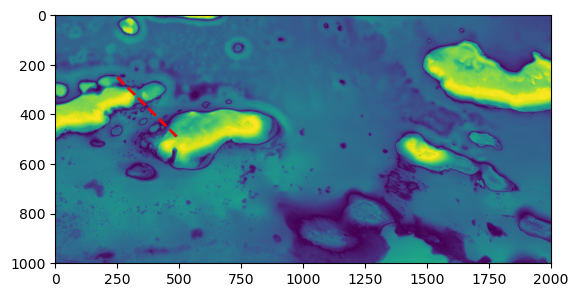

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F458C2440>

In [97]:

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)


# heatmap(bathy_map, aspect_ratio=:equal, color=:grays)
# plot!(600,600)
# plot!(x, y, color=:red, lw=2)
ax.plot([250,500],[250,500],"r--", lw=2)

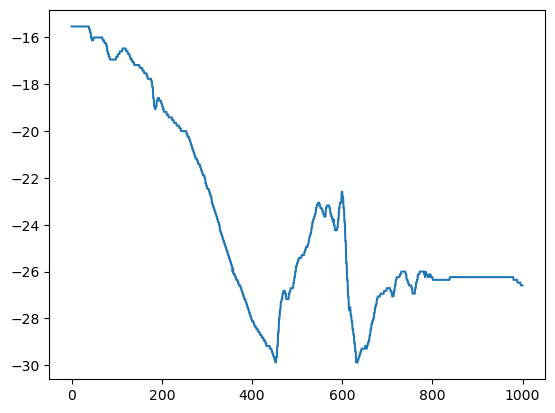

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F45639090>

In [99]:
measurements = simulate_measurements(xs, ys, bathy_map)
PyPlot.plot(ts, -measurements)

## Particle Filter

compute_likelihood (generic function with 1 method)

In [49]:
using Reel # For visualization
plot_sequence = []




5

In [50]:
# function sample_points(initial_state, noise_distribution, num_points)
#     ...
#     particles = ones(, N_PARTICLES)
    
#     for i in range(1, num_points)
#         sample = initial_state + rand.(initial_distribution)
#     end
    
#     return samples
# end

# function update_weights!(particles, dynamics_model, observation)
#     ...

# function compute_likelihood(state, observation, observation_model)
#     ...
        
#     # State vector: x, y, θ, linear velocity, angular velocity
#     x, y, θ, v, dθ = state

#     model_depth = lookup_depth(x, y, map)

#     dist = Normal(model_depth, MODEL_MEASUREMENT_STD)
#     pdf_value = pdf(dist, measurement)
    
# #     println(model_depth)
# #     println(pdf_value)
#     return pdf_value
# end

# function resample_points!(particles, weights)
#     ...
        

            

In [51]:
rand.([dist_pos_init, dist_pos_init])

2-element Vector{Float64}:
 -63.92874007791153
  96.68746732981522

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

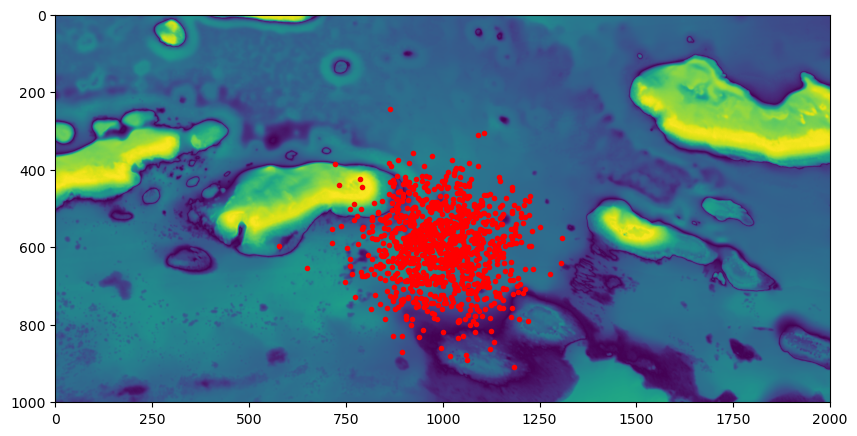

In [52]:

# INITIALIZATION ##############################################
all_particles = ones(STATE_VEC_SIZE, N_PARTICLES, N_STEPS)
particles = ones(STATE_VEC_SIZE, N_PARTICLES)
new_particles = ones(STATE_VEC_SIZE, N_PARTICLES)
weights = ones(N_PARTICLES)


dist_pos_init = Normal(0, INIT_STD_POS)
dist_rot_init = Normal(0, INIT_STD_ROT)

dist_pos_update = Normal(0, PF_STD_POS)
dist_rot_update = Normal(0, PF_STD_ROT)


for i in range(1, N_PARTICLES)
    # Generate sample
    x = START_X + rand(dist_pos_init)
    y = START_Y + rand(dist_pos_init)
    θ = START_θ + rand(dist_rot_init)
    
    particles[:,i] = particles[:,i].*[x, y, θ, 0, 0]
end

# Plot initial particles
fig, ax = PyPlot.subplots(figsize=[10,10])
ax.imshow(-bathy_map)
ax.plot(particles[1,:], particles[2,:], "r.")


# PARTICLE FILTER ##############################################
state_estimate = ones(STATE_VEC_SIZE, N_STEPS)

# pre-allocate space (avoids errors)
samples = similar(weights)

for (t_idx, (t, m, in_th, in_rud)) in enumerate(zip(ts, measurements, in_thruster, in_rudder))
    print('.')
    all_particles[:,:,t_idx] = particles
    
    
    # Update weights based on observation ---------------------
    # Compute relative likelihoods
    for (p_idx, p) in enumerate(eachcol(particles))
        weights[p_idx] = compute_likelihood(p, m, bathy_map)
        
        # Ensure likelihood can't be too small
        if weights[p_idx] < 0.000000001
            weights[p_idx] = 0.000000001
        end
    end   
    
    # Resample particles --------------------------------------
    # Normalize the weights

    
#     println("HEREEE")
#     println(size(weights))
#     println(sum(weights))
#     println(size(weights ./ sum(weights)))
    
    w_norm = Weights(weights ./ sum(weights))

    # Generate N_PARTICLES samples
    samples = sample(1:size(particles, 2), w_norm, N_PARTICLES)

    # Extract the corresponding columns from the matrix
    new_particles = particles[:, samples]
    particles = new_particles
    
    # Add noise to avoid particle death
    # TODO: Add noise to samples based on current covariances
    particles[1, :] = particles[1, :] + rand(dist_pos_update, N_PARTICLES)
    particles[2, :] = particles[2, :] + rand(dist_pos_update, N_PARTICLES)
    particles[3, :] = particles[3, :] + rand(dist_rot_update, N_PARTICLES)
    
    # Update particles with dynamics model 
    # TODO add vehicle dynamics noise? (build in noise term here)
    for (p_idx, p) in enumerate(eachcol(particles))
        particles[:,p_idx] = glider_dynamics_model(p, DELTA_T, in_th, in_rud)
    end   
    
    # Update state estimate --------------------------------------
    state_estimate[:,t_idx] = mean(particles, dims=2) # TODO: Handle angle wrap elegantly
    
#     # Visualization -------------------------------------------
#     fig, ax = PyPlot.subplots()
#     ax.imshow(-bathy_map)
#     ax.plot(particles[1,:], particles[2,:], "r.")

#     # Add the plot to the sequence
#     push!(plot_sequence, fig)
end



# w = [1,1,1,2,3,4,5,6,7]

# idxs = sample(axes(b, 1), myweights, 10)

# INITIALIZATION

# SIM_TIME = 1000 # s
# N_STEPS = 1001

# START_X = 1000 
# START_Y = 600
# START_θ = π/2

# state_vec = 
# particles



# Implement Particle filter
# - given
#     in_thruster
#     in_rudder
# - given initialization (put at map size/2)
# - randomly generate particles around starting position (x, y, theta) - Note: use gaussians here. Use defined covariance
# - plot initial particles

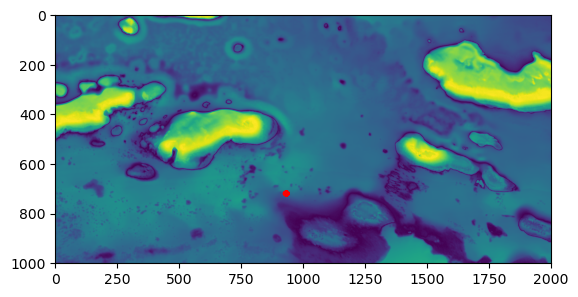

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F2BE626B0>

In [53]:
# Plot particles at step n

n = 100

fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(all_particles[1,:,n], all_particles[2,:,n], "r.")

In [54]:
# # dist_pos_init = Normal(0, INIT_STD_POS)
# dist_rot_init = Normal(0, INIT_STD_ROT)
# rand(dist_pos_init, 10) + rand(dist_pos_init, 10)

In [55]:
# frames = Frames(MIME("image/png"), fps=10)
# for plt in plot_sequence
#     print(".")
#     push!(frames, plt)
# end
# write("output.gif", frames)


# using Interact, Plots

# Define the function to plot
# f(x) = sin(x)

# Create a slider widget
# s = slider(0:0.1:2π, label="x")

# # Create a plot that updates with the slider
# plot(slider = s) do
#     plot(f.(s.value), label="sin(x)")
#     xlabel("x")
#     ylabel("y")
#     ylim(-1.1, 1.1)
# end

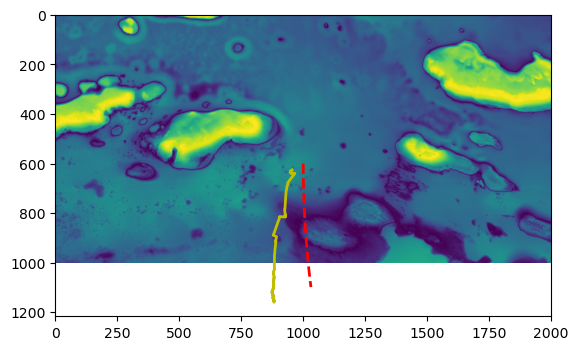

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000021F2BEE61A0>

In [56]:
# Plot result
# fig, ax = PyPlot.subplots(figsize=[10,10])
fig, ax = PyPlot.subplots()
ax.imshow(-bathy_map)
ax.plot(state_estimate[1,:], state_estimate[2,:], "y-", lw=2)
ax.plot(xs,ys,"r--", lw=2)

In [26]:
# particles = ones(STATE_VEC_SIZE, N_PARTICLES)
# A = rand(5, 10)
# row_means = mean(A, dims=2)

In [27]:
mat = rand(3,10)
display(mat)
print(size([1,1,1,1,1,2,3,4,5,100]))
w = pweights([1,1,1,1,1,2,3,4,5,1000])

idxs = sample(axes(mat,2), w, 10)

3×10 Matrix{Float64}:
 0.263024    0.534815  0.992894  0.480743  …  0.437964  0.832557  0.611114
 0.00397285  0.586192  0.795251  0.764921     0.831626  0.269864  0.142983
 0.696813    0.748456  0.229832  0.84537      0.990075  0.538914  0.956491

(10,)

10-element Vector{Int64}:
 10
 10
 10
 10
 10
 10
 10
 10
 10
 10

In [28]:
# Example data
# mat = rand(3,10)
# w_unnormalized = [1,1,1,1,1,2,3,4,5,1000]
# p = w_unnormalized / sum(w_unnormalized)
# w = 1 ./ p
# w = w / sum(w)

# # Draw a sample from x using the weights in w
# sampled_index = sample(w_unnormalized, Weights(w), 1)

# Get the value of the sampled element from x
# sampled_value = x[1,sampled_index]



# RESAMPLE STEP #####################################


# Example data
mat = rand(3, 10)
w_unnormalized = [1, 1, 1, 1, 1, 2, 3, 4, 5, 1000]

# Normalize the weights
w = w_unnormalized ./ sum(w_unnormalized)

# Generate n samples
n = 5
samples = sample(1:size(mat, 2), Weights(w), n)

# Extract the corresponding columns from the matrix
sampled_mat = mat[:, samples]


3×5 Matrix{Float64}:
 0.595189   0.595189   0.393616  0.595189   0.595189
 0.0485249  0.0485249  0.147211  0.0485249  0.0485249
 0.921648   0.921648   0.819239  0.921648   0.921648

In [29]:
axes(mat,2)

Base.OneTo(10)

In [30]:
# using StatsBase

# # Define an array of values
# x = [2, 3, 5, 2, 10]

# # Compute weights based on the relative values of the elements in x
# w = x ./ sum(x)

# # Sample an index from x based on the computed weights
# # idx = rand(SampleWeights(w))


In [31]:
# bathy_map[1,400]
# bathy_map[1,800]
# maximum(bathy_map)
# minimum(bathy_map)
# plot(bathy_map[:,1]) # column, row format. 0, 0 is top left of image



In [32]:
print(img[10,10000])

# function rgb_to_greyscale(rgb)
# end
# 0.2989, 0.5870, 0.1140.

# gray_value = Gray(img[10,10000])

# gray_img = Gray.(img)

# # Plot the grayscale image
# heatmap(gray_img, color=:grays)

# float(red(img[6000,10000]))

rgb_to_value(img[6000,10000])

RGB{N0f8}(1.0,0.0,0.0)

12.941175f0

In [33]:

# # affine_map = geotransform(geoarray)
# # plot(geoarray, band=3)
# # geoarray
# # 0.299red+0.587green+0.114blue
# # band_1 = geoarray[:,:,1]

# using GeoArrays

# # Load the GeoTIFF file into a GeoArray
# # filename = "path/to/geotiff/file.tif"
# # geoarray = GeoArrays.read(filename)

# # Define the latitude and longitude of the point of interest
# lat = 40.7128
# lon = -74.0060

# # Convert the latitude and longitude to row and column indices
# # setcrs!(geoarray, "+proj=longlat +datum=WGS84")
# # row, col = GeoArrays.coordinates(geoarray, lat, lon)

# # # Extract the RGB value at the specified location
# # rgb = geoarray[row, col, :]

# # # Convert the RGB value to depth
# # depth = 0.3048 * (rgb[1] + rgb[2] * 256 + rgb[3] * 65536)

# # # Print the depth value
# # println(depth)

In [34]:
# Define the x and y values
x = 100
y = 200

# Find the pixel with the closest x, y values
x_idx = argmin(abs.(collect(1:size(img, 2)) .- x))
y_idx = argmin(abs.(collect(1:size(img, 1)) .- y))

# Look up the pixel value
pixel_value = img[y_idx, x_idx]
print(pixel_value)

RGB{N0f8}(0.69,0.882,0.0)

### Map Generation

In [35]:
using Plots
using CalculusWithJulia
import Contour: contours, levels, lines, coordinates
using LinearAlgebra, ForwardDiff

LoadError: ArgumentError: Package CalculusWithJulia not found in current path.
- Run `import Pkg; Pkg.add("CalculusWithJulia")` to install the CalculusWithJulia package.

In [36]:
# Step 1
n = rand(5:20)

# Step 2
A = rand(-1:0.01:1, n)
B = rand(0.001:0.005:0.05, n)
f_rand(x,y) = sum(A[i]*sin.(B[i]*x) * A[i+1]*cos.(B[i+1]*y) for i in 1:n-1)


f_rand (generic function with 1 method)

In [37]:
xs = range(-200, stop=200, length=100)
ys = range(-200, stop=200, length=100)
# f(x,y) = sin(x/100)*sin(y/100)
# f(x,y) = sin(x/100)*sin(y/100)
# surface(xs, ys, f)
contour(xs, ys, f_rand)

LoadError: UndefVarError: contour not defined

In [38]:
f_rand(xs, ys)

LoadError: MethodError: no method matching *(::Vector{Float64}, ::Vector{Float64})
[0mClosest candidates are:
[0m  *(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at operators.jl:591
[0m  *([91m::StridedMatrix{T}[39m, ::StridedVector{S}) where {T<:Union{Float32, Float64, ComplexF32, ComplexF64}, S<:Real} at C:\Users\amyng\AppData\Local\Programs\Julia-1.8.5\share\julia\stdlib\v1.8\LinearAlgebra\src\matmul.jl:49
[0m  *(::StridedVecOrMat, [91m::LinearAlgebra.Adjoint{<:Any, <:LinearAlgebra.LQPackedQ}[39m) at C:\Users\amyng\AppData\Local\Programs\Julia-1.8.5\share\julia\stdlib\v1.8\LinearAlgebra\src\lq.jl:269
[0m  ...

In [39]:
using PyPlot

In [40]:
function meshgrid(x, y)
    X = [i for i in x, j in 1:length(y)]
    Y = [j for i in 1:length(x), j in y]
    return X, Y
end

meshgrid (generic function with 1 method)

### Lookup values

In [ ]:
function simulate_measurement(x,y,theta,noise=0)
    # TODO: Returns beam 1, 2, 3, 4
    return f_rand(x, y)
end

In [ ]:
# End goal: plot of real trajectory, 
# versus computed one with particle filter

## GPU code snippets

In [ ]:
# # Initialize particles
# x_d = CuArray{Float32}(START_X .+ rand(dist_pos_init, N_PARTICLES))
# y_d = CuArray{Float32}(START_Y .+ rand(dist_pos_init, N_PARTICLES))
# θ_d = CuArray{Float32}(START_θ .+ rand(dist_rot_init, N_PARTICLES))
# v_d = CUDA.fill(0.0f0, N_PARTICLES)  # a vector stored on the GPU filled with 1.0 (Float32)
# dθ_d = CUDA.fill(0.0f0, N_PARTICLES)

# # Particles = Vector containing CuArray for each state variable 
# # Vector{CuArray}(undef, 5)
# particles_d = CuArray([x_d, y_d, θ_d, v_d, dθ_d])

# # Load measurements and control inputs onto GPU
# in_thruster_d = CuArray{Float32}(in_thruster)
# in_rudder_d = CuArray{Float32}(in_rudder)

# inputs_d = [in_thruster_d, in_rudder_d]
# measurements_d = [CuArray{Float32}(measurements)]


In [ ]:
# in_thruster_32 = Float32.(in_thruster)
# in_rudder_32 = Float32.(in_rudder)

# temp = [[x, y] for (x, y) in zip(in_thruster_32, in_rudder_32)]
# a_d = CuArray(map(x -> (x[1], x[2]), temp))

# # inputs_d = cu(zip(in_thruster_32, in_rudder_32))

# # inputs_d[1]
# # [in_thruster_32, in_rudder_32]

# in_thruster_32 = Float32.(in_thruster)
# in_rudder_32 = Float32.(in_rudder)
# inputs_d = cu([in_thruster_32', in_rudder_32'])
# [in_thruster_32, in_rudder_32]

In [ ]:
# Load initial particles onto GPU (_d means stored on device)
using CUDA

# Initialize particles
x = Float32.(START_X .+ rand(dist_pos_init, N_PARTICLES))
y = Float32.(START_Y .+ rand(dist_pos_init, N_PARTICLES))
θ = Float32.(START_θ .+ rand(dist_rot_init, N_PARTICLES))
v = zeros(Float32, N_PARTICLES)
dθ = zeros(Float32, N_PARTICLES)

# Particles = Vector containing CuArray for each state variable 
# Vector{CuArray}(undef, 5)
particles = [broadcast(tuple, x[i], y[i], θ[i], v[i], dθ[i]) for i in 1:length(x)]
particles_d = CuArray(map(x -> (x[1], x[2], x[3], x[4], x[5]), particles))

# Load measurements and control inputs onto GPU
in_thruster_32 = Float32.(in_thruster)
in_rudder_32 = Float32.(in_rudder)
inputs = [[x1, x2] for (x1, x2) in zip(in_thruster_32, in_rudder_32)]
inputs_d = CuArray(map(x -> (x[1], x[2]), inputs))

measurements_32 = Float32.(measurements)
measurements_d = CuArray(map(x -> (x[1],), measurements_32));

In [ ]:
#     i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
#     if i <= length(particles[1])
#         @inbounds particles[1][i]
#     end

# function run_gpu_filter!
    
#     # Initialize weights vector
# #     weights = ones(Float32, length(particles[1]))
    
# #     weights_d = CUDA.fill(1.0f0, length(particles))
# #     particles
    
# #     for (u, y) in enumerate(zip(inputs, measurements))
# #         print('.')
        
# #         # TODO: Ensure likelihood can't be too small
# #         update_weights_gpu!(particles, u, y, weights)
# #     end
#     return
# end

# function run_gpu_filter!(particles, dynamics_model, measurement_model, inputs, measurements)
    
# end

# function update_weights_gpu!(particles, input, measurement, weights)   
#     index = (blockIdx().particles[1] - 1) * blockDim().particles[1] + threadIdx().particles[1]
#     stride = gridDim().particles[1] * blockDim().particles[1]
#     for i = index:stride:length(particles[1])       
#         # TODO: Add support for measurement models that depend on next state
#         # Replace 0 with next state data
#         @inbounds weights[i] += 10  # TODO! #measurement_model(particles[i], input, 0, measurement)
#     end
# end

# TODO: left off here
# make this use resampling_func (update particles) and propogation_func 
# At each step, save results to CPU ()

# function bench_gpu_filter!(particles, func)
    
    
    # TODO: Need to write a kernel for each parallelized function. Put the rest of the particle filter in this function,
    # including saving results
    # Custom parts = kernel functions for weighting (resampling) and propogation. start with stub, add one piece at a time. 
    # Save results at each step


#     particles[1]
#     index = (blockIdx().particles - 1) * blockDim().particles + threadIdx().particles
#     stride = gridDim().particles[1] * blockDim().particles[1]

#     for i = index:stride:length(particles[1])
#         @inbounds particles[1][1] += 2000
#     end
    # function gpu_add3!(y, x)
#     index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
#     stride = gridDim().x * blockDim().x
#     for i = index:stride:length(y)
#         @inbounds y[i] += x[i]
#     end
#     return
# end

In [ ]:

         # TODO: Optimize threads vs blocks
        # TODO: see if this can be abstracted and not run in inner loop
        # Resample particles with GPU
#         resampling_kernel = @cuda launch=false resampling_func!(particles, u, y)
#         resampling_config = launch_configuration(resampling_kernel.fun)
#         resampling_threads = min(num_particles, resampling_config.threads)
#         resampling_blocks = cld(num_particles, resampling_threads)

#         display("Resampling threads: $resampling_threads")
#         display("Resampling blocks: $resampling_blocks")

#         a = u .+ 10
#         b = y .+ 20
#     inputs
#     for (u, y) in enumerate(zip(inputs, measurements))
        
#         print(u)
#         print(y)
#         print('.')
        
        # TODO: Ensure likelihood can't be too small
#         update_weights_gpu!(particles, u, y, weights)
#     end

    
#     resampling_kernel = @cuda launch=false run_gpu_filter!(particles, inputs, measurements)
#     resampling_config = launch_configuration(kernel.fun)
#     resampling_threads = min(length(particles[1]), config.threads)
#     resampling_blocks = cld(length(particles[1]), threads)

#     display(threads)
#     display(blocks)

#     CUDA.@sync begin
#         resampling_kernel(particles, inputs, measurements; threads, blocks)
# #         kernel(particles, func; threads, blocks)
#     end
# particles_d


# function test_func!(part)
#     display(part[1])
#     display("here")
#     @cuprintln("print testing")
#     @cuprintln(part[1])
# end

# bench_gpu_filter!(particles_d, test_func!)

# test_func!(particles_d)



# # @btime bench_gpu4!($y_d, $x_d)

# # run_gpu_filter!(particles_d, inputs_d, measurements_d)

# @cuda threads=16 run_gpu_filter!(particles_d, inputs_d, measurements_d, glider_measurement_model, glider_dynamics_model)
# synchronize()


# function parallel_add!(y, x)
#     Threads.@threads for i in eachindex(y, x)
#         @inbounds y[i] += x[i]
#     end
#     return nothing
# end


        #         w_norm = Weights(weights ./ sum(weights))

#         # Generate N_PARTICLES samples
#         samples = sample(1:size(particles, 2), w_norm, N_PARTICLES)

#         # Extract the corresponding columns from the matrix
#         new_particles = particles[:, samples]
#         particles = new_particles

#         # Add noise to avoid particle death
#         # TODO: Add noise to samples based on current covariances
#         particles[1, :] = particles[1, :] + rand(dist_pos_update, N_PARTICLES)
#         particles[2, :] = particles[2, :] + rand(dist_pos_update, N_PARTICLES)
#         particles[3, :] = particles[3, :] + rand(dist_rot_update, N_PARTICLES)

        
#         _bathy_map[1]
#         @inbounds particles[3, i] = 
#         @inbounds particles[4, i] = likelihood
        
                #         @inbounds particles[1, i] += i + _bathy_map[1,1]
#         @inbounds particles[2, i] += i + _bathy_map[1,1]

In [ ]:
# particles_d
# weights_d

# all_particles = Array{Float32}(undef, N_PARTICLES, 5, N_STEPS)

# # Don't use this - it takes literally forever
# copyto!(view(all_particles, :,:,1), all_particles_d[1])

# all_particles[:,:,1]

# for (idx, p) in enumerate(all_particles_d)
#     print('.')
#     copyto!(view(all_particles, :,:,idx), all_particles_d[idx])
# end

# all_particles[:,:,1]

# for p in all_particles_d
# end
# # Array(all_particles_d)
# for 
# all_particles[1]
# all_particles[1]
# all_particles_d[1]

In [ ]:
# Dyanmics Model
function glider_dynamics_model(x, u, rng)
    """
    inputs:
        x: state
        u: control input
    output:
        updated state (same shape as x)
    """
    x_pos, y_pos, θ, v, dθ = x
    in_thruster, in_rudder = u
    
    # Update position based on state
    x_step = x_pos + DELTA_T*v*cos(θ)
    y_step = y_pos + DELTA_T*v*sin(θ)
    θ_step = θ + DELTA_T*dθ

    # Update velocities based on input
    v_step = v + DELTA_T*(in_thruster-v)
    dθ_step = dθ + DELTA_T*in_rudder
    
    return [x_step, y_step, θ_step, v_step, dθ_step]
end

# Measurement model (computes likelihood of measurement, given previous state, action, and current state)
# Note: our measurement only depends on current state
function glider_measurement_model(x1, u, x2, y)
    """
    inputs:
        x1: current state
        u: control input
        x2: next state
        y: measurement
    output:
        likelihood (float)
    """
    
    # State vector: x, y, θ, linear velocity, angular velocity
    x_pos, y_pos, θ, v, dθ = x2
    measured_depth = y

    model_depth = lookup_depth(x_pos, y_pos, bathy_map)

    dist = Normal(model_depth, MODEL_MEASUREMENT_STD)
    pdf_value = pdf(dist, measured_depth)

    return pdf_value
end

In [ ]:
const SIM_TIME = 1000 # s
const N_STEPS = 1001

const SIM_MEASUREMENT_STD = 10 # Noise of simulated measurement
const MODEL_MEASUREMENT_STD = 0.2#10.0 #0.1 # Modeled noise value
const ϵ = 0.000001 # Minimum particle likelihood value, to avoid errors

ts = range(0, stop=SIM_TIME, length=N_STEPS)

# TODO: remove fixed timestamp
const DELTA_T = ts[2] - ts[1]
rng = MersenneTwister(1)

# Particle filter parameters
N_PARTICLES = 1000
INIT_STD_POS = 100 # Positional standard deviation
INIT_STD_ROT = 1 # Rotational standard deviation (radians)

PF_STD_POS = 0.1 # Positional standard deviation for particle filter updates
PF_STD_ROT = 0.01 # Positional standard deviation for particle filter updates


STATE_VEC_SIZE = 5 # x, y, θ, linear velocity, angular velocity

In [ ]:


using DelimitedFiles
writedlm("x.txt", xs)
writedlm("y.txt", ys)
writedlm("θ.txt", θs)
writedlm("v.txt", vs)
writedlm("dθ.txt", dθs)
writedlm("thrust.txt", in_thruster)
writedlm("rudder.txt", in_rudder)
writedlm("u.txt", measurements)

In [ ]:
function test_func()
    return 5
end

results = @benchmark test_func() evals=1 samples=1 
a = test_func()

# TODO: Generate dataset given parameters

# xs, ys, θs, vs, dθs = simulate_trajectory(ts, in_thruster, in_rudder, 
#     start_x=START_X, start_y=START_Y, start_θ=START_θ, delta_t=DELTA_T)

# measurements = simulate_measurements(xs, ys, bathy_map);
# SIM_MEASUREMENT_STD = 10 # Noise of simulated measurement
# MODEL_MEASUREMENT_STD = 0.2 # Modeled noise value
# ϵ = 0.000001 # Minimum particle likelihood value, to avoid particle death

In [ ]:
# function bench_pf_gpu(
#         n_particles, init_std_pos, init_std_rot, measurement_std, bathy_map, # Modelling params
#         start_x, start_y, start_θ, sim_time, n_steps, input_func, # Dataset params
#         num_evals, num_samples) # Benchmarking params
    
#     dist_pos_init = Normal(0, init_std_pos)
#     dist_rot_init = Normal(0, init_std_rot)
    
#     xs, ys, θs, vs, dθs, in_thruster, in_rudder, measurements = 
#         generate_data(start_x, start_y, start_θ, sim_time, n_steps, input_func, bathy_map, measurement_std)

#     # Initialize particles
#     x = Float32.(start_x .+ rand(dist_pos_init, n_particles))
#     y = Float32.(start_y .+ rand(dist_pos_init, n_particles))
#     θ = Float32.(start_θ .+ rand(dist_rot_init, n_particles))
#     v = zeros(Float32, n_particles)
#     dθ = zeros(Float32, n_particles)

#     # Load particles onto GPU
#     particles_d = CuArray([x y θ v dθ])

#     # Load measurements and control inputs onto GPU
#     in_thruster_32 = Float32.(in_thruster)
#     in_rudder_32 = Float32.(in_rudder)
#     inputs_d = [CuArray([in_thruster_32[i], in_rudder_32[i]]) for i in 1:length(in_thruster_32)]

#     measurements_32 = Float32.(measurements)
#     measurements_d = [CuArray([measurements_32[i],]) for i in 1:length(measurements_32)];
    
#     # Format data
#     # TODO: Make struct with other constants
#     bathy_map_d = CuArray(bathy_map);
    
#     # Allocate space for particle output
#     output_particles_d = [similar(particles_d) for i in 1:n_steps]
    
#     # Run filter
#     runfiltergpu!(particles_d, inputs_d, measurements_d, 
#         glider_reweight_kernel!, glider_propogate_kernel!, output_particles_d, bathy_map_d)
# end